# Simpson Character Classification

This is a project for the university course 'AKT - Deep Learning and Computer Vision'.

## Introduction

The goal of this project is to classify pictures of simpson characters. 
It is based on this kaggle dataset: https://www.kaggle.com/alexattia/the-simpsons-characters-dataset

The dataset consists of images of a number of characters which makes it a multi-class image classification problem.

We used the following approach to conduct this project:

1. Data Exploration: We gain understanding for the dataset, e.g.: how classes are distributed
2. Data Preparation: Before feeding the images into a modell, we prepare the data, to improve the results
3. Modeling: Different models are built and tested
4. Evaluation: We analyze the performance of the models and compare them

## Data Exploration

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
%matplotlib inline

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


The dataset is organized into subfolders named by the character the images inside show.
There was one subfolder "simpsons_dataset" which wasn't belonging to any character, therefore we deleted it.

### Loading the images

In [3]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, #rescale rgb value to a value between 0 and 1
                                                                        validation_split=0.2)


In [4]:
train_dir = "D:\ML\simpsons\simpsons_dataset"
#train_dir = "./data/simpsons_dataset/"
IMG_HEIGHT, IMG_WIDTH = 64, 64
batch_size = 8

# data generator for training data
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='training',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))
# data generator for validation data
val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='validation',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 16764 images belonging to 42 classes.
Found 4169 images belonging to 42 classes.


In [5]:
num_classes = len(train_data_gen.class_indices)
num_steps = len(train_data_gen)
num_val_steps = len(val_data_gen)
print( 'Number of classes : {}'.format(num_classes))
print( 'Number of steps (training data) : {}'.format(num_steps))
print( 'Number of steps (validation data) : {}'.format(num_val_steps))

Number of classes : 42
Number of steps (training data) : 2096
Number of steps (validation data) : 522


### Analyze number of images per class

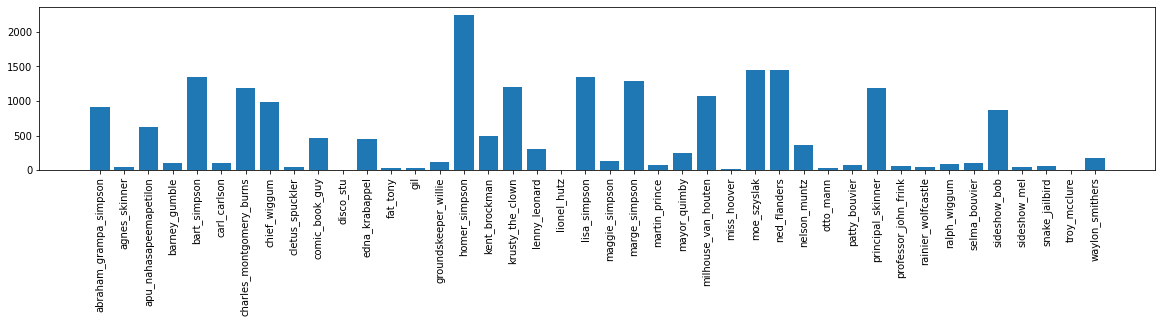

                    class  count
            homer_simpson   2246
             ned_flanders   1454
              moe_szyslak   1452
             lisa_simpson   1354
             bart_simpson   1342
            marge_simpson   1291
         krusty_the_clown   1206
        principal_skinner   1194
 charles_montgomery_burns   1193
      milhouse_van_houten   1079
             chief_wiggum    986
   abraham_grampa_simpson    913
             sideshow_bob    877
   apu_nahasapeemapetilon    623
            kent_brockman    498
           comic_book_guy    469
           edna_krabappel    457
             nelson_muntz    358
            lenny_leonard    310
             mayor_quimby    246
          waylon_smithers    181
           maggie_simpson    128
     groundskeeper_willie    121
            barney_gumble    106
            selma_bouvier    103
             carl_carlson     98
             ralph_wiggum     89
            patty_bouvier     72
            martin_prince     71
     profe

In [6]:
classnames=os.listdir(train_dir)
class_count_array = []
for d in classnames:
    class_count_array.append(len(os.listdir(os.path.join(train_dir, d))))
data = {'class': classnames, 'count': class_count_array}
data_dict = dict(zip(classnames, class_count_array))

plt.figure(figsize=(20, 3))
plt.bar(data_dict.keys(), data_dict.values())
plt.xticks(rotation='vertical')
plt.show()

df = pd.DataFrame(data).sort_values('count', ascending=False)
print(df.to_string(index=False))

The histogram above shows that the images per classes are heavily imbalanced.
It is difficult to predict classes with few images correctly e.g.: lionel_hutz

### Displaying examples of the dataset

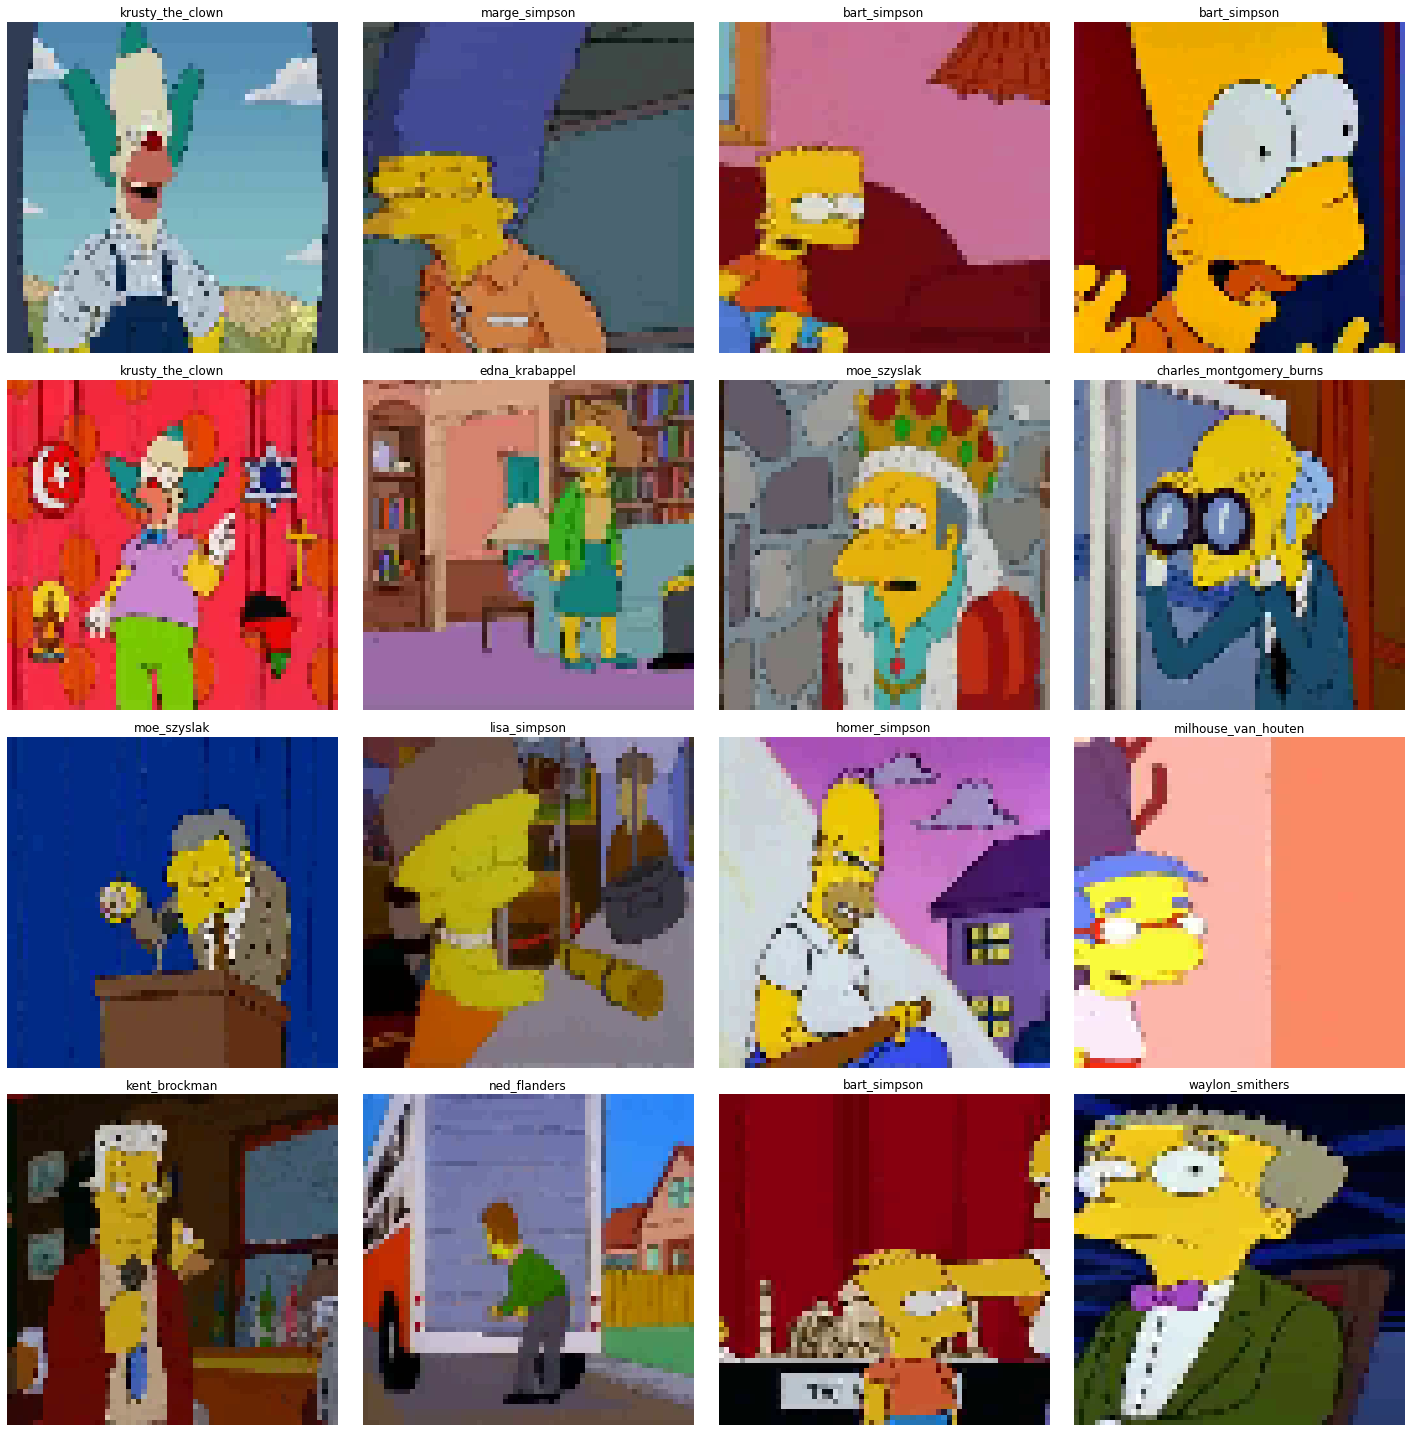

In [7]:
sample_training_images1, labels1 = next(train_data_gen)
sample_training_images2, labels2 = next(train_data_gen)
sample_training_images = np.concatenate((sample_training_images1, sample_training_images2), axis=0)
labels = np.concatenate((labels1, labels2), axis=0)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(4, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

In [8]:
from easyimages import EasyImageList
list = EasyImageList.from_folder("./homer_simpson")
list.html(sample=500, size=44)

### Analyzing the aspect ratio of the images

In [9]:
import functools
import operator 
classnames=os.listdir(train_dir)
ratio_dict = dict()
for d in classnames:
    subfolderImgs = os.listdir(os.path.join(train_dir, d))
    for img in subfolderImgs:
        im = cv2.imread(os.path.join(train_dir, d, img))
        curr_ratio = im.shape[1] / im.shape[0]
        if curr_ratio in ratio_dict:
            ratio_dict[curr_ratio] = ratio_dict[curr_ratio] + 1
        else:
            ratio_dict[curr_ratio] = 1

d:\tmp\akt_image-classification\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  after removing the cwd from sys.path.


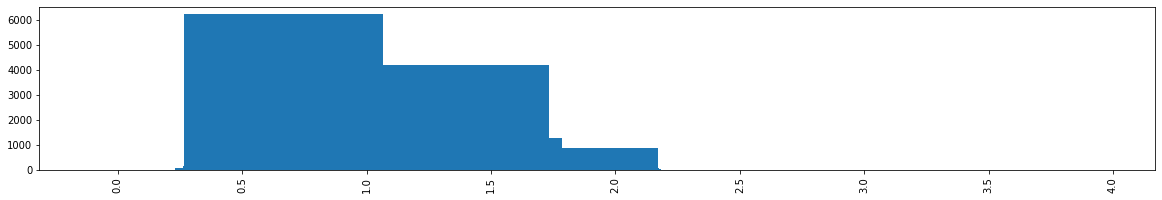

In [10]:
plt.figure(figsize=(20, 3))
plt.bar(ratio_dict.keys(), ratio_dict.values())
plt.xticks(rotation='vertical')
plt.show()

The histogram above shows that the aspect ratio of the images vary.
The images need to be resized.

##  Data Preparation and Modeling

In [11]:
def get_model_small(): 
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [12]:
# model with extra dense layer
def get_model_big(): 
    model = Sequential()
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(512)) # add dense layer
    model.add(Activation('relu')) 
    model.add(Dropout(0.5)) 
    model.add(Dense(num_classes)) 
    model.add(Activation('softmax'))
    return model

In [59]:
model_small = get_model_small()
model_small.compile(optimizer='adam', #defines how the weights are adjusted
              loss='categorical_crossentropy', #evaluates how well our algo models the dataset,
              metrics=['accuracy']) #additional info

In [60]:
model_small.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_14 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_15 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 31, 31, 64)       

In [61]:
model_big = get_model_big()
model_big.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
activation_19 (Activation)   (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_20 (Activation)   (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 31, 31, 64)       

* no of params big model: 6.510.154
* no of params small model: 592.458

The big model will take a longer time to train.

In [15]:
#define callback functions

snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='max')

ACCURACY_THRESHOLD = 0.90
class accCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
        
acc_callback = accCallback()


#### Model1: small model + no augmentation + adam optimizer

In [50]:
#start training of the model
history = model_small.fit(train_data_gen, 
                      steps_per_epoch=500, # num_steps
                      validation_data=val_data_gen,
                      validation_steps=200, # num_val_steps
                      epochs=100,
                      callbacks=[snapshot_callback, early_stopping]) # use early stopping
model_small.save('model1')

Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 2.9169 - accuracy: 0.1950
Epoch 00001: saving model to .\snapshots
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\snapshots\assets
500/500 [==============================] - 44s 87ms/step - loss: 2.9169 - accuracy: 0.1950 - val_loss: 2.6123 - val_accuracy: 0.2812
Epoch 2/100
500/500 [==============================] - ETA: 0s - loss: 2.3332 - accuracy: 0.3790
Epoch 00002: saving model to .\snapshots
INFO:tensorflow:Assets written to: .\snapshots\assets
500/500 [==============================] - 43s 87ms/step - loss: 2.3332 - accuracy: 0.3790 - val_loss: 2.3981 - val_accuracy: 0.3481
Epoch 3/100
500/500 [==============================] - ETA: 0s - loss: 1.9787 - accuracy: 0.4655
Epoch 00003: saving

In [16]:
def plot_history_loss(history): 
    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'], '--', label="loss")
    plt.plot(history.history['val_loss'], '--', label="val_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
def plot_history_acc(history): 
    plt.figure(figsize=(15,7))
    plt.plot(history.history['accuracy'], '--', label="accuracy")
    plt.plot(history.history['val_accuracy'], '--', label="val_accuracy")
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
def plot_history(history):
    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'], '--', label="loss")
    plt.plot(history.history['val_loss'], '--', label="val_loss")
    plt.plot(history.history['accuracy'], '-', label="accuracy")
    plt.plot(history.history['val_accuracy'], '-', label="val_accuracy")
    plt.xlabel('epoch')
    plt.ylabel('loss / acc')
    plt.legend()

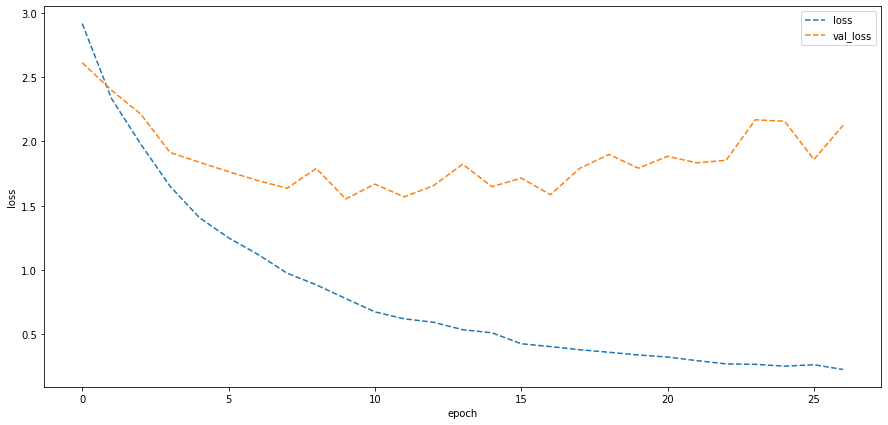

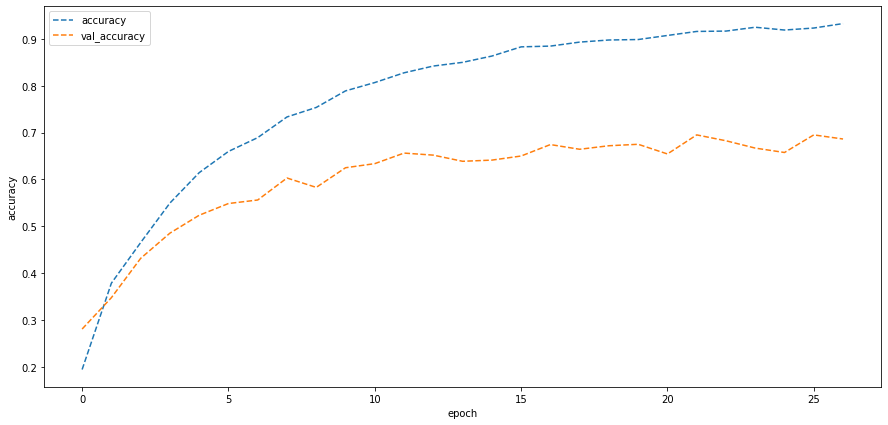

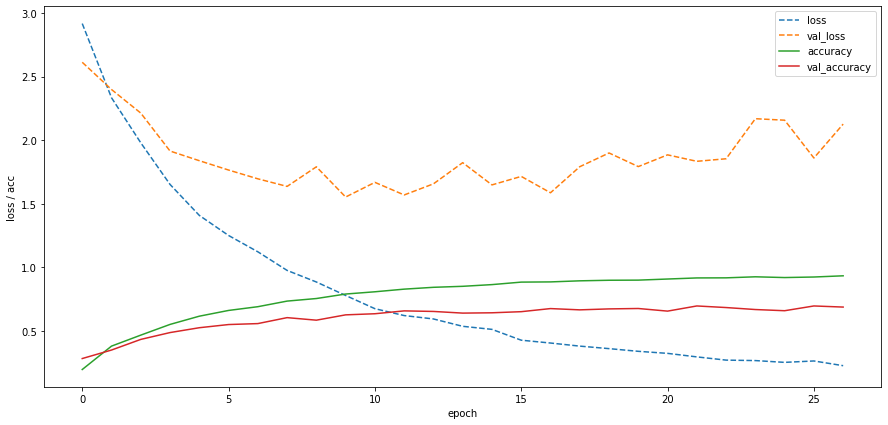

In [65]:
plot_history_loss(history)
plot_history_acc(history)
plot_history(history)

#### Model2: small model + no augmentation + rmsprop optimizer

In [18]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots2",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs2")
model2 = get_model_small()
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model2.save('model2')

Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 3.1064 - accuracy: 0.1177
Epoch 00001: saving model to .\snapshots2
INFO:tensorflow:Assets written to: .\snapshots2\assets
500/500 [==============================] - 7s 15ms/step - loss: 3.1064 - accuracy: 0.1177 - val_loss: 2.9388 - val_accuracy: 0.1444
Epoch 2/100
495/500 [============================>.] - ETA: 0s - loss: 2.8758 - accuracy: 0.2027
Epoch 00002: saving model to .\snapshots2
INFO:tensorflow:Assets written to: .\snapshots2\assets
500/500 [==============================] - 7s 15ms/step - loss: 2.8746 - accuracy: 0.2032 - val_loss: 2.8223 - val_accuracy: 0.2094
Epoch 3/100
497/500 [============================>.] - ETA: 0s - loss: 2.7077 - accuracy: 0.2752
Epoch 00003: saving model to .\snapshots2
INFO:tensorflow:Assets written to: .\snapshots2\assets
500/500 [==============================] - 7s 15ms/step - loss: 2.7096 - accuracy: 0.2745 - val_loss: 2.6618 - val_accuracy: 0.2881
Epoch 4/100
497/500 [=

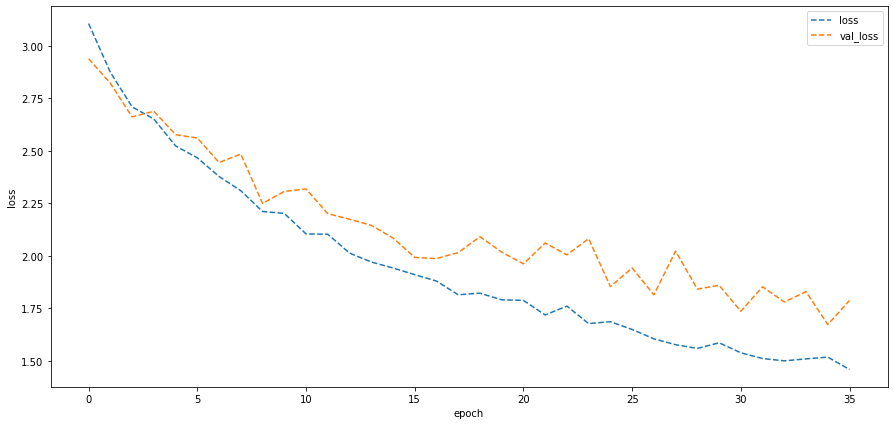

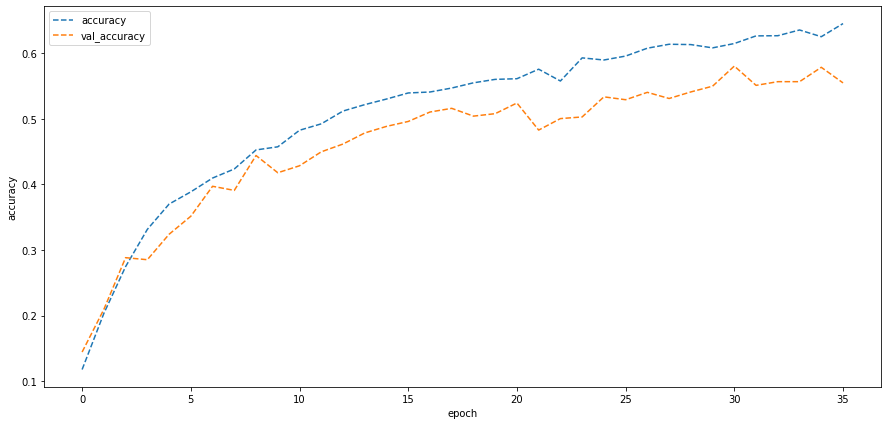

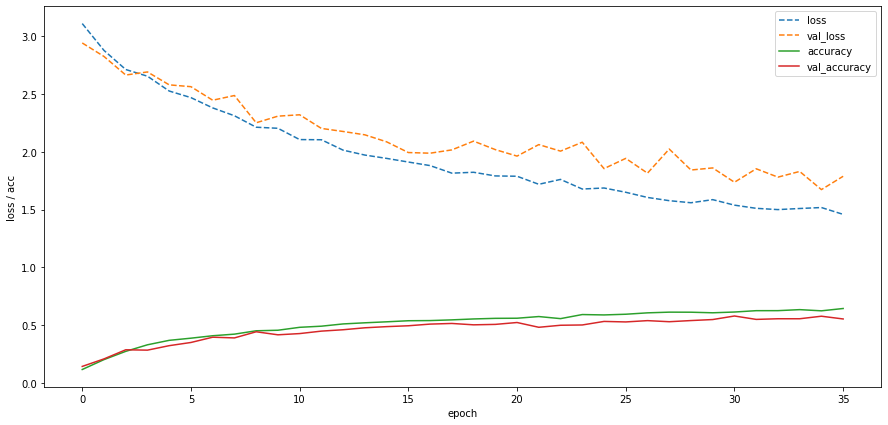

In [19]:
plot_history_loss(history2)
plot_history_acc(history2)
plot_history(history2)

### Data Augmentation 
We tried make our model more robust by adding data augmentaion

In [20]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                        validation_split=0.2,
                                                                        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                                                                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                                                        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                                                        horizontal_flip=True,  # randomly flip images
                                                                        vertical_flip=False)

In [21]:
train_dir = "D:\ML\simpsons\simpsons_dataset"
IMG_HEIGHT, IMG_WIDTH = 64, 64
batch_size = 8

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='training',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='validation',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 16764 images belonging to 42 classes.
Found 4169 images belonging to 42 classes.


#### Model3: small model + augmentation + rmsprop

In [22]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots3",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs3")

model3 = get_model_small()
model3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model.save('model3')

Epoch 1/100
499/500 [============================>.] - ETA: 0s - loss: 3.1120 - accuracy: 0.1155
Epoch 00001: saving model to .\snapshots3
INFO:tensorflow:Assets written to: .\snapshots3\assets
500/500 [==============================] - 13s 26ms/step - loss: 3.1107 - accuracy: 0.1163 - val_loss: 2.9695 - val_accuracy: 0.1656
Epoch 2/100
498/500 [============================>.] - ETA: 0s - loss: 2.8663 - accuracy: 0.2038
Epoch 00002: saving model to .\snapshots3
INFO:tensorflow:Assets written to: .\snapshots3\assets
500/500 [==============================] - 13s 26ms/step - loss: 2.8655 - accuracy: 0.2037 - val_loss: 2.8324 - val_accuracy: 0.2156
Epoch 3/100
499/500 [============================>.] - ETA: 0s - loss: 2.7694 - accuracy: 0.2518
Epoch 00003: saving model to .\snapshots3
INFO:tensorflow:Assets written to: .\snapshots3\assets
500/500 [==============================] - 13s 25ms/step - loss: 2.7695 - accuracy: 0.2515 - val_loss: 2.7297 - val_accuracy: 0.2675
Epoch 4/100
497/500

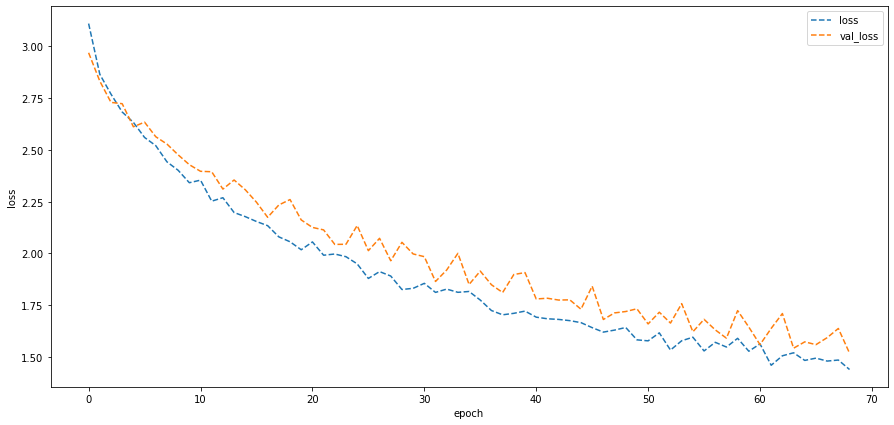

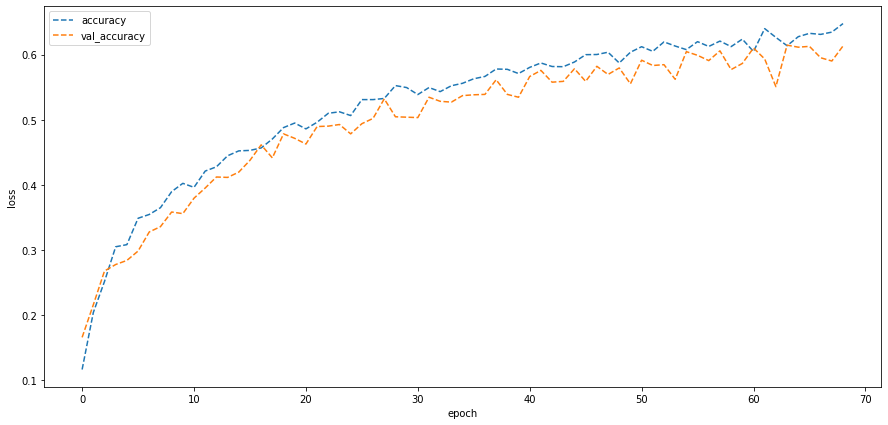

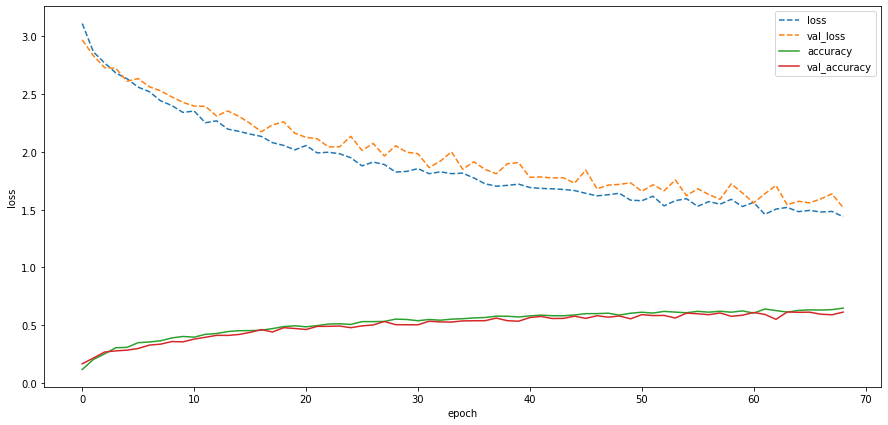

In [23]:
plot_history_loss(history3)
plot_history_acc(history3)
plot_history(history3)

#### Model4: small model + augmentation + adam

In [24]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots4",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs4")

model4 = get_model_small()
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history4 = model4.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model4.save('model4')

Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 2.9059 - accuracy: 0.1875
Epoch 00001: saving model to .\snapshots4
INFO:tensorflow:Assets written to: .\snapshots4\assets
500/500 [==============================] - 13s 26ms/step - loss: 2.9059 - accuracy: 0.1875 - val_loss: 2.7007 - val_accuracy: 0.2500
Epoch 2/100
498/500 [============================>.] - ETA: 0s - loss: 2.4551 - accuracy: 0.3386
Epoch 00002: saving model to .\snapshots4
INFO:tensorflow:Assets written to: .\snapshots4\assets
500/500 [==============================] - 13s 26ms/step - loss: 2.4564 - accuracy: 0.3383 - val_loss: 2.3280 - val_accuracy: 0.3894
Epoch 3/100
499/500 [============================>.] - ETA: 0s - loss: 2.1911 - accuracy: 0.4153
Epoch 00003: saving model to .\snapshots4
INFO:tensorflow:Assets written to: .\snapshots4\assets
500/500 [==============================] - 13s 26ms/step - loss: 2.1896 - accuracy: 0.4157 - val_loss: 2.1741 - val_accuracy: 0.4363
Epoch 4/100
500/500

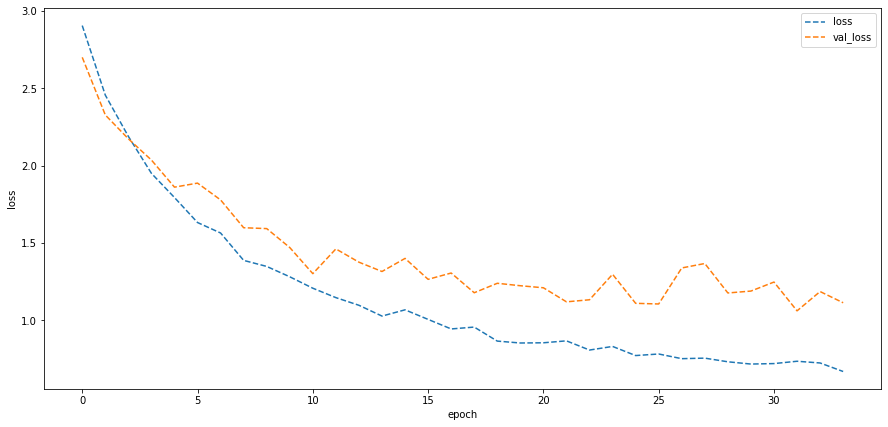

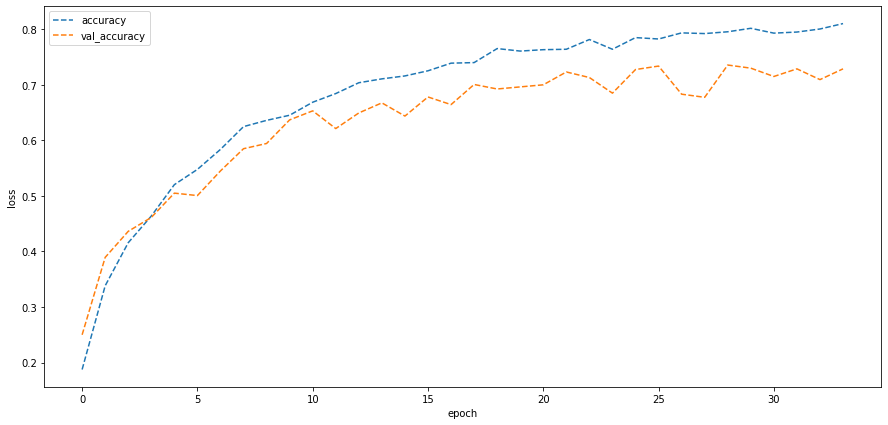

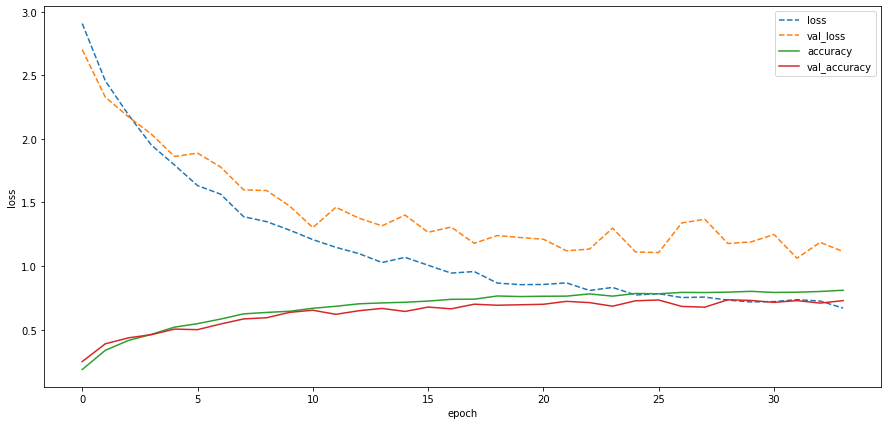

In [25]:
plot_history_loss(history4)
plot_history_acc(history4)
plot_history(history4)

#### Model adam: big model + augmentation + adam

In [ ]:
adam = get_model_big()
adam.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
adam_history = adam.fit(train_data_gen, 
                    steps_per_epoch=num_steps,
                    validation_data=val_data_gen,
                    validation_steps=num_val_steps,
                    epochs=300,
                    callbacks=[early_stopping]) # use early stopping
adam.save('adam')

In [ ]:
plot_history_loss(adam_history)
plot_history_acc(adam_history)
plot_history(adam_history)

This model was trained using the cpu. 
We tried to train it on gpu but the pc kept crashing.

## Evaluation
In this section we test the different models using the test data set.
We then compare the reports and find out which model yields the best results.

In [23]:
import glob
import sklearn
from sklearn.metrics import confusion_matrix

def load_test_set(path):
    pics, labels = [], []
    reverse_dict = train_data_gen.class_indices
    for pic in glob.glob(path+'*.*'):
        char_name = "_".join(pic.split('\\')[4].split('_')[:-1])
        if char_name in reverse_dict:
            temp = cv2.imread(pic)
            temp = cv2.resize(temp, (64,64)).astype('float32') / 255.
            temp = temp[...,::-1]
            pics.append(temp)
            labels.append(reverse_dict[char_name])
    X_test = np.array(pics)
    y_test = np.array(labels)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    print("Test set", X_test.shape, y_test.shape)
    return X_test, y_test

X_test, y_test = load_test_set(".\\data\\kaggle_simpson_testset\\kaggle_simpson_testset\\")

Test set (990, 64, 64, 3) (990, 42)


In [8]:
def stats_every_character(y_pred, y_test):
    report = []
    true_pos_tot = 0
    names = []
    space_max = np.max([len(name) for name in train_data_gen.class_indices.keys()])
    report.append('{s}{space}{s2}{space2}{s3}'.format(s='character', 
                                          space= ' ' * (space_max + 2 - len("character")), 
                                          s2='Precision',
                                          space2= '  ', 
                                          s3='Support'))
    for name, id_char in train_data_gen.class_indices.items():
        idx_char = [i for i, x in enumerate(np.argmax(y_pred, axis= 1) == id_char) if x]
        true_pos = np.sum(np.argmax(y_test[idx_char], axis=1) == np.argmax(y_pred[idx_char], axis=1))
        if(len(idx_char) == 0):
            continue
        true_pos_tot += true_pos
        names.append(name.replace('_',' ').title())
        report.append('{s}{space}{f:.2f}{space2}{s3}'.format(s=name.replace('_',' ').title(), 
                                                             space= ' ' * (space_max + 4 - len(name)), 
                                                             f=true_pos/len(idx_char),
                                                             space2 = ' '*6,
                                                             s3 = len(idx_char)))
    report.append('{s}{space}{f:.2f}{space2}{s3}'.format(s="Total", 
                                             space= ' ' * (space_max + 4 - len('Total')), 
                                             f=true_pos_tot/len(y_test),
                                             space2 = ' '*6,
                                             s3 = len(y_pred)))

    #names.append("Total")
    return report, names

## Model1: small model + no augmentation + adam optimizer

In [11]:
predict_model = tf.keras.models.load_model('model1')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [13]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))


                           precision    recall  f1-score   support

  Abraham Grampa Simpson       0.97      0.62      0.76        48
  Apu Nahasapeemapetilon       0.92      0.92      0.92        50
           Barney Gumble       0.00      0.00      0.00         0
            Bart Simpson       0.77      0.92      0.84        50
Charles Montgomery Burns       0.67      0.85      0.75        48
            Chief Wiggum       0.96      0.88      0.92        50
          Comic Book Guy       0.94      0.90      0.92        49
          Edna Krabappel       0.95      0.80      0.87        50
    Groundskeeper Willie       0.00      0.00      0.00         0
           Homer Simpson       0.63      0.92      0.75        50
           Kent Brockman       0.95      0.80      0.87        50
        Krusty The Clown       0.94      0.94      0.94        50
           Lenny Leonard       0.97      0.78      0.87        50
            Lisa Simpson       1.00      0.74      0.85        50
       

## Model2: small model + no augmentation + rmsprop optimizer

In [14]:
predict_model = tf.keras.models.load_model('model2')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [15]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))

ValueError: Number of classes, 20, does not match size of target_names, 19. Try specifying the labels parameter

Unfortunately we had problems to generate a report for model 2.

## Model3: small model + augmentation + rmsprop

In [16]:
predict_model = tf.keras.models.load_model('model3')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [17]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))


                           precision    recall  f1-score   support

  Abraham Grampa Simpson       0.97      0.62      0.76        48
  Apu Nahasapeemapetilon       0.92      0.92      0.92        50
           Barney Gumble       0.00      0.00      0.00         0
            Bart Simpson       0.77      0.92      0.84        50
Charles Montgomery Burns       0.67      0.85      0.75        48
            Chief Wiggum       0.96      0.88      0.92        50
          Comic Book Guy       0.94      0.90      0.92        49
          Edna Krabappel       0.95      0.80      0.87        50
    Groundskeeper Willie       0.00      0.00      0.00         0
           Homer Simpson       0.63      0.92      0.75        50
           Kent Brockman       0.95      0.80      0.87        50
        Krusty The Clown       0.94      0.94      0.94        50
           Lenny Leonard       0.97      0.78      0.87        50
            Lisa Simpson       1.00      0.74      0.85        50
       

## Model4: small model + augmentation + adam

In [18]:
predict_model = tf.keras.models.load_model('model4')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [19]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))


                           precision    recall  f1-score   support

  Abraham Grampa Simpson       0.94      0.65      0.77        48
           Agnes Skinner       0.00      0.00      0.00         0
  Apu Nahasapeemapetilon       0.98      0.88      0.93        50
            Bart Simpson       0.87      0.78      0.82        50
            Carl Carlson       0.00      0.00      0.00         0
Charles Montgomery Burns       0.74      0.83      0.78        48
            Chief Wiggum       0.87      0.94      0.90        50
         Cletus Spuckler       0.00      0.00      0.00         0
          Comic Book Guy       0.95      0.71      0.81        49
          Edna Krabappel       0.93      0.82      0.87        50
    Groundskeeper Willie       0.00      0.00      0.00         0
           Homer Simpson       0.68      0.88      0.77        50
           Kent Brockman       0.95      0.84      0.89        50
        Krusty The Clown       0.86      0.98      0.92        50
       

##  Model Adam: big model + augmentation + adam

In [21]:
predict_model = tf.keras.models.load_model('adam')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [22]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))


                           precision    recall  f1-score   support

  Abraham Grampa Simpson       0.93      0.81      0.87        48
  Apu Nahasapeemapetilon       0.92      0.90      0.91        50
            Bart Simpson       0.85      0.82      0.84        50
            Carl Carlson       0.00      0.00      0.00         0
Charles Montgomery Burns       0.78      0.83      0.81        48
            Chief Wiggum       0.90      0.92      0.91        50
          Comic Book Guy       1.00      0.92      0.96        49
          Edna Krabappel       0.98      0.84      0.90        50
           Homer Simpson       0.62      0.94      0.75        50
           Kent Brockman       0.91      0.84      0.87        50
        Krusty The Clown       0.98      0.88      0.93        50
           Lenny Leonard       1.00      0.88      0.94        50
            Lisa Simpson       0.81      0.78      0.80        50
           Marge Simpson       0.88      0.98      0.92        50
       

We analyze the performance of a model by generating a report.
The reports prints various metrics for each of the classes.

* TP -> TruePositiv
* TN -> TrueNegativ
* FP -> FalsePositiv
* FN -> FalseNegativ

* Precision: 
    * TP / (TP + FP)
    * the number of correctly identified positiv results divided by the number of all positive results   
* Recall (also called sensitivity): 
    * TP / (TP + FN)
    * the number of correctly identified positive results divided by the number of all samples that should have been identified as positive.
* F1-score: 
    * The harmonic mean of Precision and Recall

In general the precisions of the classes vary greatly. 
The models recognize images of classes with many trainingsexamples 
much better than images of classes with only few trainingsexamples.
This makes sense, as more examples of a class allow the models to
better learn the features of this class.

Example using model 'Adam':

* 'Abraham Grandpa Simpson'
    * precision: 0.93
    * number of samples: 913 
* 'Agnes Skinner'  
    * precision: 0.0
    * number of samples: 42

When comparing the results of the models it show that
model 'adam' yields the best results.
It reached a weighted avg accuracy of 0.9.

Model Adam is by far the most complex model we used and it therefore  took
the longest time to train. 
We assume that increasing the complexity could yield even better
results, but we didn't test that as the available hardware was already reaching it's limit.